# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# План проекта

1. Загрузить данные из файла и получить информацию.
2. Найти и изучить пропущенные значения в столбцах:\
    а) Определить в каких столбцах есть пропуски\
    б) Заполнить пропуски там, где это возможно\
    в) Указать причины, которые могли привести к пропускам в данных
3. Рассмотреть типы данных в столбцах:\
    а) Найти столбцы, в которые нужно заменить тип данных\
    б) Преобразовать тип данных в столбцах\
    в) Объяснить причину изменения данных
4. Изучить уникальные значения в столбце с названиями и устранить неявные дубликаты.
5. Найти и устранить редкие значения:\
    а) Восстановить корректные значения там, где необходимо\
    б) Удалить выбивающиеся значения\
    в) Описать обнаруженные особенности в данных
6. Добавить новые столбцы:\
    а) Цена одного квадрата\
    б) День недели публикации объявления (0-понедельник, вторник-1 и т.д.)\
    в) Месяц,год публикации объявления\
    г) Тип этажа квартиры ("первый", "последний", "другой")\
    д) Расстояние до центра города в километрах (округлить до целого числа)
7. Провести исследовательский анализ и построить отдельные гистограммы для каждого из параметров.
    1) Изучить параметры объектов:
        а) общая площадь
        б) жилая площадь
        в) площадь кухни
        г) цена объекта
        д) кол-во комнат
        е) высота потолков
        ж) этаж квартиры
        з) тип этажа квартиры
        и) общее кол-во этажей
        й) расстояние до центра города в м
        к) расстояние до ближайшего аэропорта
        л) расстояние до ближайшего парка
        м) день и месяц публикации объявления
8. Изучить, как быстро продавались квартиры (days_exposition):
    1) Построить гистограмму
    2) Посчитать среднее и медиану
    3) Описать сколько времени обычно занимает продажа и какие продажи можно считать долгими
9. Изучить влияние факторов на общую стоимость объекта и построить графики зависимости цены и фактора. Например, общая площадь, жилая площадь, площадь кухни, кол-во комнат, этажа, даты размещения объявления.
10. Посчитать среднюю цену 1 кв.м. в населенных пунктах с наибольшим числом объявлений. Выделить населенные пункты с самой высокой и низкой стоимостью кв.м.
11. Вычислить среднюю цену каждого километра от квартиры до центра города в Санкт-Петербурге.
12. Описать полученные результаты и написать общий вывод.

### Открыть файл с данными и изучить общую информацию 

Открываем файл через путь: '/datasets/real_estate_data.csv' и выводим необходимую информацию через функции 'read_csv', 'data.info()', 'data.hist()'. При выгрузке данных используем дополнительный аргумент sep='\t'(от англ. separate - разделять), чтобы придать таблице читабельный вид.

In [1]:
import pandas as pd
import seaborn as sns #импортируем seaborn как sns для создания статистических графиков
import matplotlib.pyplot as plt #импортируем matplotlib как plt для визуализации данных

try:
    data = pd.read_csv('/Users/losky/Downloads/real_estate_data.csv',sep='\t')
except FileNotFoundError:
    data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

data.info()
print(data.head(10))
data.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

23699

Построим для наглядности гистограммы для каждого числового столбца таблицы. Для этого вызовем функцию hist().

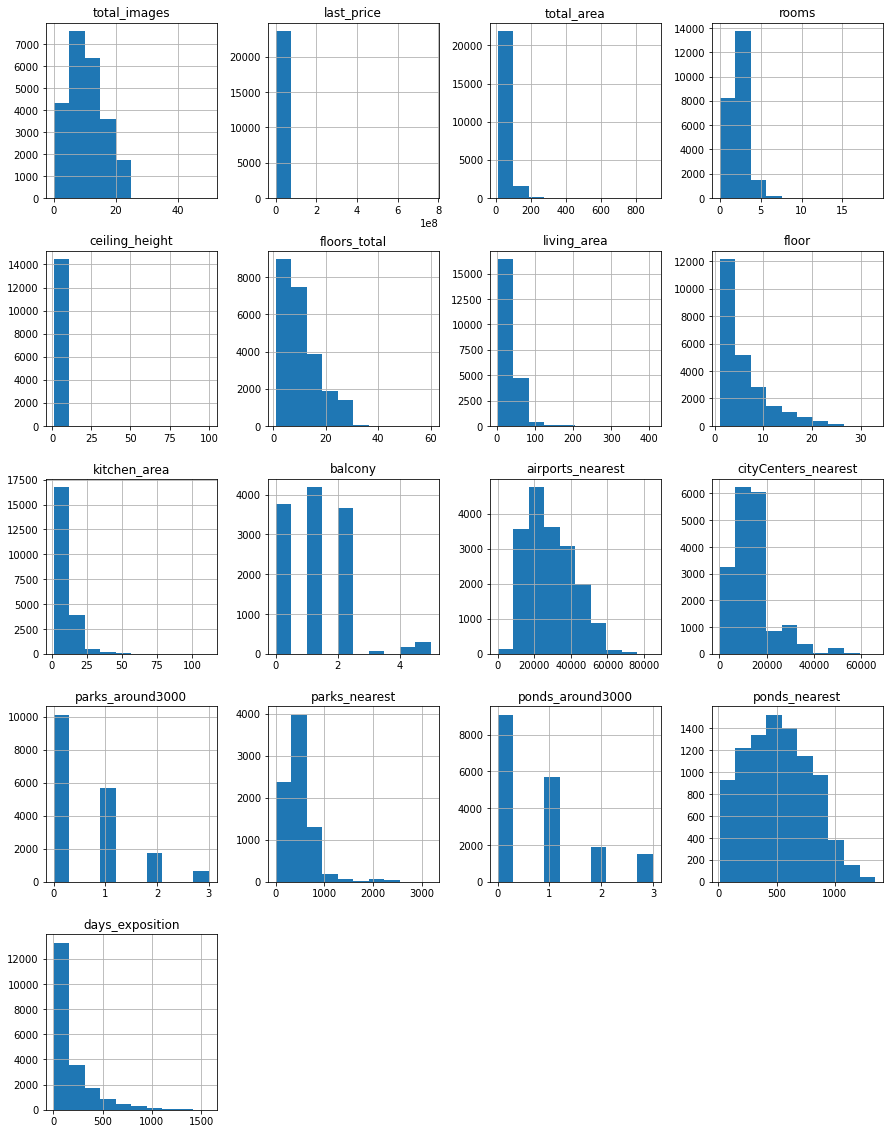

In [2]:
data.hist(figsize=(15, 20));

Из первичных данных удалось выяснить, что в данных присутствуют пропуски в данных, столбец "cityCenters_nearest" имеет верхний регистр, в некоторых столбцах неправильно использованный тип данных. Перейдем к предобработке данных, чтобы устранить все эти недочёты.

### Предобработка данных

Переименуем столбцы и поменяем их местами по приоритетности информации, чтобы при первом взгляде на них было понятно, какие данные в нём содержатся и можно было просто ориентироваться:

In [3]:
data = data[[
 'locality_name',  
 'total_area',
 'living_area',
 'kitchen_area',
 'ceiling_height',
 'rooms',
 'balcony',
 'floor',
 'floors_total',
 'is_apartment',
 'studio',
 'open_plan',  
 'total_images',
 'last_price',
 'first_day_exposition',
 'days_exposition',
 'cityCenters_nearest',
 'airports_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest'
]]

In [4]:
colum= [
 'locality_name',  
 'total_area',
 'living_area',
 'kitchen_area',
 'ceiling_height',
 'rooms',
 'balcony',
 'floor',
 'floors_total',
 'is_apartment',
 'studio',
 'open_plan',  
 'total_images',
 'last_price',
 'first_day_exposition',
 'days_exposition',
 'citycenter_m',
 'airports_m',
 'parks_3km',
 'parks_nearest_m',
 'ponds_3km',
 'ponds_nearest_m'
]
data.set_axis(colum, axis='columns', inplace=True)

Определим в каких столбцах присутствуют пустые значения. Вызовем функцию поиска isna() и суммируем их при помощи sum().

In [5]:
data.isna().sum()

locality_name              49
total_area                  0
living_area              1903
kitchen_area             2278
ceiling_height           9195
rooms                       0
balcony                 11519
floor                       0
floors_total               86
is_apartment            20924
studio                      0
open_plan                   0
total_images                0
last_price                  0
first_day_exposition        0
days_exposition          3181
citycenter_m             5519
airports_m               5542
parks_3km                5518
parks_nearest_m         15620
ponds_3km                5518
ponds_nearest_m         14589
dtype: int64

В столбце 'ceiling_height' можно заметить потолки выше, чем 2,5 м, что говорит об аномальных значениях. Возможно при вводе высоты потолка произошла опечатка. Разделим значения выше 10 м на 10 и снова посмотрим на отклонения в данных.

In [6]:
data['ceiling_height'].sort_values(ascending=False)

22869    100.0
22336     32.0
3148      32.0
21377     27.5
20478     27.0
         ...  
23687      NaN
23690      NaN
23692      NaN
23695      NaN
23696      NaN
Name: ceiling_height, Length: 23699, dtype: float64

In [7]:
data.loc[(data['ceiling_height'] > 10), 'ceiling_height'] = data['ceiling_height'] / 10
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)
data['ceiling_height'].isna().sum()
data['ceiling_height'].describe()

count    23699.000000
mean         2.697798
std          0.237643
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         10.000000
Name: ceiling_height, dtype: float64

Большая часть столбцов в данных имеет нулевые значения. Теперь нужно определить причину появления Nan значений в данных и, где возможно, устранить их. Сразу заменим пустые значения в столбце "balcony" на 0.

In [8]:
data.loc[data['balcony'].isnull(), 'balcony'] = 0

Удалим строки с этажностью дома, так как их удаление не повлечёт за собой нарушения структуры данных и результатов в целом.

In [9]:
data.drop(data[data['floors_total'].isnull()].index, inplace=True)

Следующим шагом следует проверить столбец "is_apartment" и за одно кол-во комнат, так как возможно, что удаление данных может повлиять на данный столбец.

In [10]:
print(data['rooms'].value_counts())
data['is_apartment'].value_counts()

1     8015
2     7913
3     5795
4     1177
5      325
0      194
6      104
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64


False    2725
True       50
Name: is_apartment, dtype: int64

Попробуем удалить квартиры с нулевым значением и посмотрим, повлияет ли это действие на кол-во апартаментов.

In [11]:
data.drop(data[data['rooms'] == 0].index,inplace=True)
data['is_apartment'].value_counts()

False    2719
True       50
Name: is_apartment, dtype: int64

Количество аппартаментов не изменилось, значит их не затронуло удаление.

Также можно удалить строки в столбце 'locality_name', так как без населенного пункта данные становятся бесполезными для проведения аналитики:

In [12]:
data.drop(data[data['locality_name'].isna()].index, inplace=True)
data['locality_name'].isna().sum()

0

В столбце Nan значения изменим на 0 при помощи функции fillna():

In [13]:
data['is_apartment'] = data['is_apartment'].fillna(0)
data['is_apartment'].isna().sum()

0

In [14]:
import datetime as dt

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_year'] = data['first_day_exposition'].dt.year
data[data['days_exposition'].isnull()].pivot_table(columns = 'first_day_year', values = 'total_area', aggfunc = 'count')

first_day_year,2014,2015,2016,2017,2018,2019
total_area,18,68,67,271,954,1779


Необходимо произвести замену пустых значений при помощи медианого значения там, где это возможно. Вызовем цикл for, чтобы заполнить пропуски в столбцах 'living_area' и 'kitchen_area':

In [15]:
for rooms in data['rooms'].unique():
    #заполним пропуски total_area:
    data.loc[(data['total_area'].isna()) & (data['rooms'] == rooms), 'total_area'] = \
    data[data['rooms'] == rooms]['total_area'].median()

living_area_ratio =\
data[data['rooms'] == rooms]['living_area'].median() / data[data['rooms'] == rooms]['total_area'].median()
data.loc[data['living_area'].isna(), 'living_area'] = living_area_ratio * data['total_area']
#заполняем пропуски в площади кухни (найдем соотношение медианной общей площади и медианной площади кухни, затем
#отношение общей площади к найденному соотношению)
kitchen_area_ratio =\
data[data['rooms'] == rooms]['kitchen_area'].median() / data[data['rooms'] == rooms]['total_area'].median()
data.loc[data['kitchen_area'].isna(), 'living_area'] = kitchen_area_ratio * data['total_area']
    
print('Медианная площадь кухни:',data['kitchen_area'].median())
print('Медианная жилая площадь:',data['living_area'].median())
print('Медианная общая площадь:',data['total_area'].median())

Медианная площадь кухни: 9.1
Медианная жилая площадь: 29.0
Медианная общая площадь: 52.0


<AxesSubplot:>

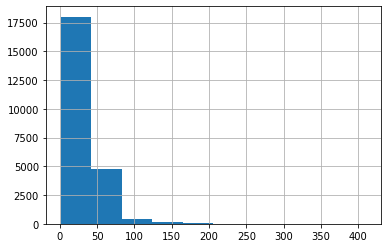

In [16]:
data['living_area'].hist()

<AxesSubplot:>

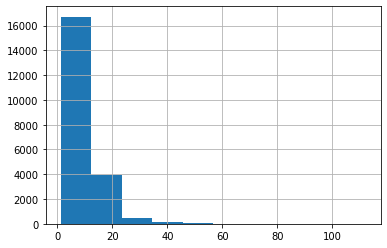

In [17]:
data['kitchen_area'].hist()

Осталось только заменить типы данных в столбцах. Поменяем float на int там, где нет необходимости в указании дробной части.

In [18]:
data['balcony'] = data['balcony'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')
data['last_price'] = data['last_price'].astype('int')

Выясним наличие явных дубликатов в назвниях населенных пунктов, вызвав функцию поиска дубликатов:

In [19]:
data.duplicated().sum()
data['locality_name'].value_counts()

Санкт-Петербург                     15542
посёлок Мурино                        494
посёлок Шушары                        435
Всеволожск                            392
Пушкин                                369
                                    ...  
садовое товарищество Новая Ропша        1
деревня Пижма                           1
поселок Семиозерье                      1
посёлок Пансионат Зелёный Бор           1
посёлок Шугозеро                        1
Name: locality_name, Length: 362, dtype: int64

Изменим регистр в столбце на нижний и обратимся к столбцу 'locality_name' через unique() и посмотрим наличие неявных дубликатов:

In [20]:
data['locality_name'] = data['locality_name'].str.lower()
print(data['locality_name'].unique())
print(data['locality_name'].value_counts())

['санкт-петербург' 'посёлок шушары' 'городской посёлок янино-1'
 'посёлок парголово' 'посёлок мурино' 'ломоносов' 'сертолово' 'петергоф'
 'пушкин' 'деревня кудрово' 'коммунар' 'колпино'
 'поселок городского типа красный бор' 'гатчина' 'поселок мурино'
 'деревня фёдоровское' 'выборг' 'кронштадт' 'кировск'
 'деревня новое девяткино' 'посёлок металлострой'
 'посёлок городского типа лебяжье' 'посёлок городского типа сиверский'
 'поселок молодцово' 'поселок городского типа кузьмоловский'
 'садовое товарищество новая ропша' 'павловск' 'деревня пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк'
 'деревня куттузи' 'посёлок аннино' 'поселок городского типа ефимовский'
 'посёлок плодовое' 'деревня заклинье' 'поселок торковичи'
 'поселок первомайское' 'красное село' 'посёлок понтонный' 'сясьстрой'
 'деревня старая' 'деревня лесколово' 'посёлок новый свет' 'сланцы'
 'село путилово' 'ивангород' 'мурино' 'шлиссельбург' 'никольское'
 'зеленогорск' 'сосновый бор' 'поселок новый све

Сразу бросается в галаза разница написания слова *посёлок*. В одном случае пишется литера "ё", а в другом "е". Изменим в данном слове на букву "е". Также заменим "деревня" на "поселок" и "городской поселок" на "поселок городского типа".

In [21]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')
data['locality_name'] = data['locality_name'].str.replace('деревня','поселок')
data['locality_name'] = data['locality_name'].str.replace('село','поселок')
data['locality_name'] = data['locality_name'].str.replace('попоселокк','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')

print(len(data['locality_name'].value_counts()))
data['locality_name'].unique()

316


array(['санкт-петербург', 'поселок шушары',
       'поселок городского типа янино-1', 'поселок парголово',
       'поселок мурино', 'ломоносов', 'сертолово', 'петергоф', 'пушкин',
       'поселок кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'поселок фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'поселок новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'поселок пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'поселок куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'поселок заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное поселок', 'поселок понтонный', 'сясьстрой',
       'поселок старая', 'поселок лесколово', 'по

Посмотрим окончательный вид предобработки данных при помощи функции *info()*:

In [22]:
data.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23371 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   locality_name         23371 non-null  object        
 1   total_area            23371 non-null  float64       
 2   living_area           23371 non-null  float64       
 3   kitchen_area          21343 non-null  float64       
 4   ceiling_height        23371 non-null  float64       
 5   rooms                 23371 non-null  int64         
 6   balcony               23371 non-null  int64         
 7   floor                 23371 non-null  int64         
 8   floors_total          23371 non-null  int64         
 9   is_apartment          23371 non-null  object        
 10  studio                23371 non-null  bool          
 11  open_plan             23371 non-null  bool          
 12  total_images          23371 non-null  int64         
 13  last_price      

**Вывод:**
В процессе предобработки было изменено название столбца 'citycenters_nearest'(исправлен регистр), заменён строковый формат на *datetime64*, убраны строки с пустыми значения, которые не повлияют на дальнешие расчеты, а остальные оставлены без изменений, жилые и другие площади были заполнены медианными значениями. Близлежащие парки, пруды и аэропорты были заполнены средними значениями. Неявные дубликаты в названиях населенных пунктов были убраны. Дальше работа пойдёт проще!

Рассмотрим какая доля от изначального кол-ва данных осталась после предобработки. Следуя из разницы показателей (23699-23371), то таблица уменьшилась на 238 строк.

In [23]:
data.shape[0]

23371

### Посчитайте и добавьте в таблицу новые столбцы

Первым делом посчитаем цену 1 кв.м. и добавим отдельный столбец. Чтобы посчитать цену за кв.м. разделим столбец 'last_price' на 'total_price' и округлим значение до сотых.

In [24]:
data['price_meter'] = data['last_price'] / data['total_area']
data['price_meter'] = data['price_meter'].round(decimals=2)

Следующий шаг: добавление столбцов дня, месяца и года публикации объявления.

In [25]:
#рассчитаем и добавим в таблицу день недели, месяц и год публикации объявления
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M:%S')
data['day'], data['month'], data['year']  = \
data['first_day_exposition'].dt.weekday, data['first_day_exposition'].dt.month, data['first_day_exposition'].dt.year

In [26]:
#рассчитаем и добавим в таблицу этаж квартиры; варианты — первый, последний, другой
def category_floor(i):
    try:
        if i['floor'] == 1:
            return 'первый'
        if i['floor'] == i['floors_total']:
            return 'последний'
        return 'другой'
    except:
        pass
data['flat_floor'] = data.apply(category_floor, axis = 1)  
data['flat_floor'].value_counts()

другой       17161
последний     3319
первый        2891
Name: flat_floor, dtype: int64

In [27]:
#добавим столбец с расстоянием км до центра
data['citycenter_m'] = data['citycenter_m'] / 1000
data['citycenter_m'] = data['citycenter_m'].round()
data['citycenter_m'].describe()

count    17947.000000
mean        14.191898
std          8.639353
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: citycenter_m, dtype: float64

In [28]:
data.head(10)

,locality_name,total_area,living_area,kitchen_area,ceiling_height,rooms,balcony,floor,floors_total,is_apartment,...,parks_3km,parks_nearest_m,ponds_3km,ponds_nearest_m,first_day_year,price_meter,day,month,year,flat_floor
0,санкт-петербург,108.00,51.000000,25.00,2.70,3,0,8,16,0,...,1.0,482.0,2.0,755.0,2019,120370.37,3,3,2019,другой
1,поселок шушары,40.40,18.600000,11.00,2.65,1,2,1,11,0,...,0.0,NaN,0.0,NaN,2018,82920.79,1,12,2018,первый
2,санкт-петербург,56.00,34.300000,8.30,2.65,2,0,4,5,0,...,1.0,90.0,2.0,574.0,2015,92785.71,3,8,2015,другой
3,санкт-петербург,159.00,19.786667,NaN,2.65,3,0,9,14,0,...,2.0,84.0,3.0,234.0,2015,408176.10,4,7,2015,другой
4,санкт-петербург,100.00,32.000000,41.00,3.03,2,0,13,14,0,...,2.0,112.0,1.0,48.0,2018,100000.00,1,6,2018,другой
5,поселок городского типа янино-1,30.40,14.400000,9.10,2.65,1,0,5,12,0,...,NaN,NaN,NaN,NaN,2018,95065.79,0,9,2018,другой
6,поселок парголово,37.30,10.600000,14.40,2.65,1,1,6,26,0,...,0.0,NaN,0.0,NaN,2017,99195.71,3,11,2017,другой
7,санкт-петербург,71.60,32.593911,18.90,2.65,2,2,22,24,0,...,0.0,NaN,0.0,NaN,2019,110544.69,3,4,2019,другой
8,поселок мурино,33.16,15.430000,8.81,2.65,1,0,26,27,0,...,NaN,NaN,NaN,NaN,2018,87454.76,2,5,2018,другой
9,санкт-петербург,61.00,43.600000,6.50,2.50,3,2,7,9,0,...,0.0,NaN,0.0,NaN,2017,88524.59,6,2,2017,другой


### Проведите исследовательский анализ данных

Изучим основные параметры квартир: площадь, цена, число комнат, высота потолков, но для начала уберем редкие и выбивающиеся значения (*аномалии*). Обратимся к данным в нужных столбцах через функцию describe().

In [29]:
data[
    ['total_area',
     'last_price',
     'rooms',
     'ceiling_height',
     'days_exposition']
].describe()

,total_area,last_price,rooms,ceiling_height,days_exposition
count,23371.000000,2.337100e+04,23371.000000,23371.000000,20214.000000
mean,60.580161,6.566584e+06,2.087844,2.697661,181.368458
std,35.613640,1.094248e+07,1.066362,0.237800,220.094368
min,12.000000,1.219000e+04,1.000000,1.000000,1.000000
25%,40.200000,3.450000e+06,1.000000,2.600000,45.000000
50%,52.000000,4.650000e+06,2.000000,2.650000,96.000000
75%,70.000000,6.800000e+06,3.000000,2.700000,232.000000
max,900.000000,7.630000e+08,19.000000,10.000000,1580.000000


 Создадим функцию, определяющую границы "усов" для задаваемого признака для поиска и удаления выбросов:

In [30]:
def whiskers(column):
    quantile = data[column].describe()
    iqr = quantile[6] - quantile[4] # межквартильный размах (для краткости iqr) 
    
    left_whisker = round(quantile[4] - 1.5 * iqr, 2) #выводим переменную для "левого уса"
    right_whisker = round(quantile[6] + 1.5 * iqr, 2)#и также для правого

    #напишем условие, что левый "ус" не должен быть меньше минимального значения
    if left_whisker < quantile[3]: left_whisker = quantile[3] 
        
    #напишем условие, что правый "ус" не должен быть больше максимального значения
    if right_whisker > quantile[7]: right_whisker = quantile[7]
        
    return [left_whisker, right_whisker]

Используем функцию на 1-м столбце ('total_area') и заодно проверим её работу:

In [31]:
whiskers('total_area')
#в результате были получены "усы", которые видны ниже

[12.0, 114.7]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


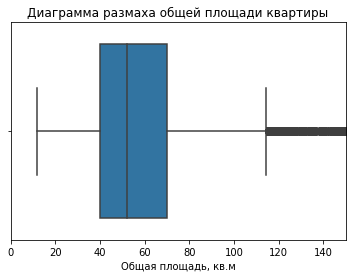

In [32]:
#построим диаграмму размаха (boxplot), ограничив площадь 150 кв.м
sns.boxplot(data['total_area'])
plt.title('Диаграмма размаха общей площади квартиры')
plt.xlabel('Общая площадь, кв.м')
plt.xlim(0, 150)
plt.show()

Теперь визуализируем полученные данные, построив диаграмму для объектов. Условие будет, что площадь не будет больше 120кв.м.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


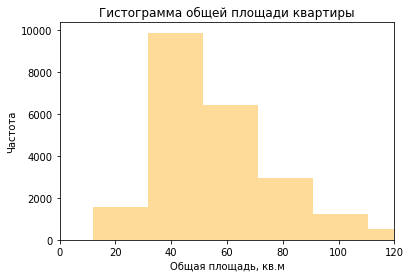

In [33]:
sns.distplot(data['total_area'],kde=False, bins=45, color = 'orange')
#пропишем дополнительный агрумент kde, чтобы убрать параметрическую линию
plt.xlim(0, 120)
plt.title('Гистограмма общей площади квартиры')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Частота')
plt.show()

Зададим функцию, вычисляющую долю аномальных значений и посчитаем аномальные значения в общей площади.

In [34]:
#зададим функцию, вычисляющую долю аномальных значений
def anomalies_ratio(column):
    return 'Аномальные значения составляют {:.1%}'. format(len(data.loc[data[column] > whiskers(column)[1]]) / len(data))
anomalies_ratio('total_area')

'Аномальные значения составляют 5.3%'

Такую же работу проделаем для остальных столбцов:

In [35]:
whiskers('last_price')

[12190.0, 11825000.0]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


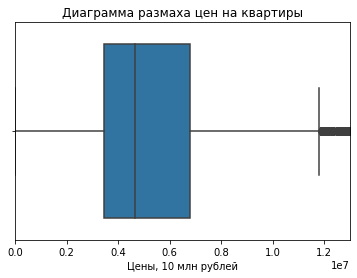

In [36]:
sns.boxplot(data['last_price'])
plt.title('Диаграмма размаха цен на квартиры')
plt.xlabel('Цены, 10 млн рублей')
_ = plt.xlim(0, 13000000)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


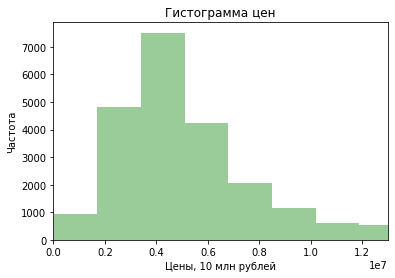

In [37]:
sns.distplot(data['last_price'], kde=False, bins=450, color = 'green')
plt.xlim(0, 13000000)
plt.title('Гистограмма цен')
plt.xlabel('Цены, 10 млн рублей')
_ = plt.ylabel('Частота')

In [38]:
anomalies_ratio('last_price')

'Аномальные значения составляют 8.8%'

In [39]:
whiskers('rooms')

[1.0, 6.0]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


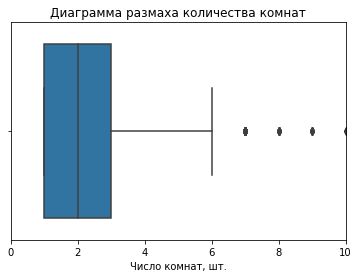

In [40]:
sns.boxplot(data['rooms'])
plt.title('Диаграмма размаха количества комнат')
plt.xlabel('Число комнат, шт.')
_ = plt.xlim(0, 10)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


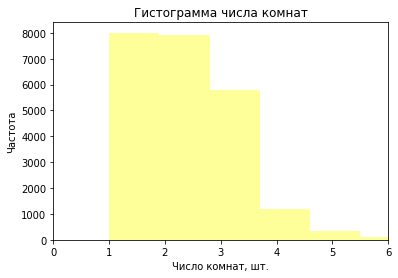

In [41]:
sns.distplot(data['rooms'], kde=False, bins=20, color = 'yellow')
plt.xlim(0, 6)
plt.title('Гистограмма числа комнат')
plt.xlabel('Число комнат, шт.')
_ = plt.ylabel('Частота')

In [42]:
anomalies_ratio('rooms')

'Аномальные значения составляют 0.4%'

In [43]:
whiskers('ceiling_height')

[2.45, 2.85]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


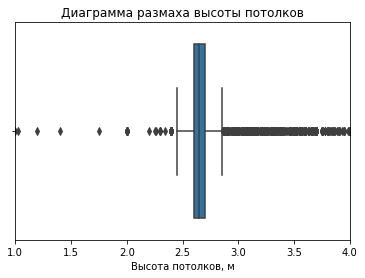

In [44]:
sns.boxplot(data['ceiling_height'])
plt.title('Диаграмма размаха высоты потолков')
plt.xlabel('Высота потолков, м')
plt.xlim(1, 4)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


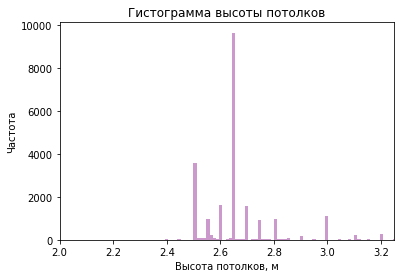

In [45]:
sns.distplot(data['ceiling_height'], kde=False, bins=750, color = 'purple')
plt.xlim(2, 3.25)
plt.title('Гистограмма высоты потолков')
plt.xlabel('Высота потолков, м')
_ = plt.ylabel('Частота')

In [46]:
anomalies_ratio('ceiling_height')

'Аномальные значения составляют 12.3%'

In [47]:
whiskers('days_exposition')

[1.0, 512.5]

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


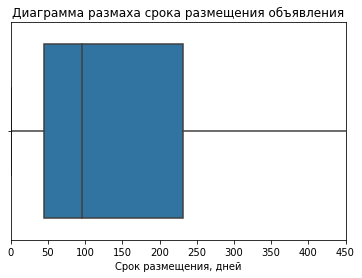

In [48]:
sns.boxplot(data['days_exposition'])
plt.title('Диаграмма размаха срока размещения объявления')
plt.xlabel('Срок размещения, дней')
_ = plt.xlim(0, 450)

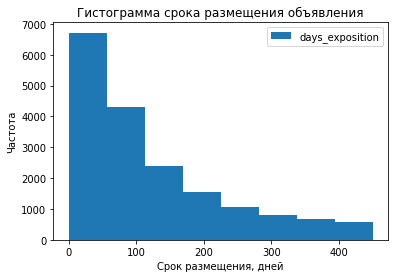

In [49]:
data.plot(y='days_exposition', 
    kind='hist',
    range=(0, 450), 
    bins=8)
plt.title('Гистограмма срока размещения объявления')
plt.xlabel('Срок размещения, дней')
_ = plt.ylabel('Частота')

In [50]:
#Соберем все аномальные значения в отдельные столбцы
data['too_large_area'] = data['total_area'] > whiskers('total_area')[1]
data['too_expensive'] = data['last_price'] > whiskers('last_price')[1]
data['unusual_ceiling'] = (data['ceiling_height'] > whiskers('ceiling_height')[1]) \
                        | (data['ceiling_height'] < whiskers('ceiling_height')[0])

#Составим таблицу с чистыми данными
good_data = data[(data['too_large_area'] == False) & 
     (data['too_expensive'] == False) &
     (data['unusual_ceiling'] == False)].reset_index(drop=True)

print('Доля чистых значений составила: {:.0%}'. format(len(good_data) / len(data)))

Доля чистых значений составила: 82%


In [51]:
good_data[['total_area', 'last_price', 'rooms', 'ceiling_height', 'days_exposition']].describe()

,total_area,last_price,rooms,ceiling_height,days_exposition
count,19272.000000,1.927200e+04,19272.000000,19272.000000,17031.000000
mean,51.555699,4.623958e+06,1.890826,2.627392,168.349128
std,16.828101,2.053804e+06,0.857446,0.081316,206.423212
min,12.000000,1.219000e+04,1.000000,2.450000,1.000000
25%,38.500000,3.250000e+06,1.000000,2.560000,43.000000
50%,47.600000,4.281273e+06,2.000000,2.650000,89.000000
75%,61.700000,5.650000e+06,3.000000,2.650000,212.000000
max,114.500000,1.180967e+07,6.000000,2.850000,1580.000000


In [52]:
good_data.shape[0]

19272

In [53]:
good_data.shape[0] / data.shape[0] * 100

82.46116982585255

## Вывод:
Исследовав данные, мы теперь можем определить параметры средней квартиры выставленной на продажу:

* двухкомнатная квартира;
* площадь 52 квадратных метра;
* потолки 2.65 метра;
* цена 4,76 млн.;

Были найдены следующие аномальные значения:

* квартиры с 7 и более комнатами;
* квартиры с площадями от 150 квадратов (это могут быть пентхаусы и таунхаусы);
* низкие потолки до 2 метров и очень большие от 4 метров;
* огромные цены в 20,30 и больше млн (хотя в нынешних реалиях это нормально)
* квартиры размещенные более года назад 

Очень долгими продажами можно признать квартиры, объявление у которых висит больше года. Это говорит о завышенной цене, или плохой транспортной доступности, или иной причине. Если квартира продавалась за 30 дней и меньше, то это говорит о низкой цене или о срочности продажи квартиры.

**Выясним, какие факторы больше всего влияют на общую (полную) стоимость объекта. Построим графики, которые покажут зависимость цены от указанных ниже параметров.**

In [54]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19272 entries, 0 to 19271
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   locality_name         19272 non-null  object        
 1   total_area            19272 non-null  float64       
 2   living_area           19272 non-null  float64       
 3   kitchen_area          17576 non-null  float64       
 4   ceiling_height        19272 non-null  float64       
 5   rooms                 19272 non-null  int64         
 6   balcony               19272 non-null  int64         
 7   floor                 19272 non-null  int64         
 8   floors_total          19272 non-null  int64         
 9   is_apartment          19272 non-null  object        
 10  studio                19272 non-null  bool          
 11  open_plan             19272 non-null  bool          
 12  total_images          19272 non-null  int64         
 13  last_price      

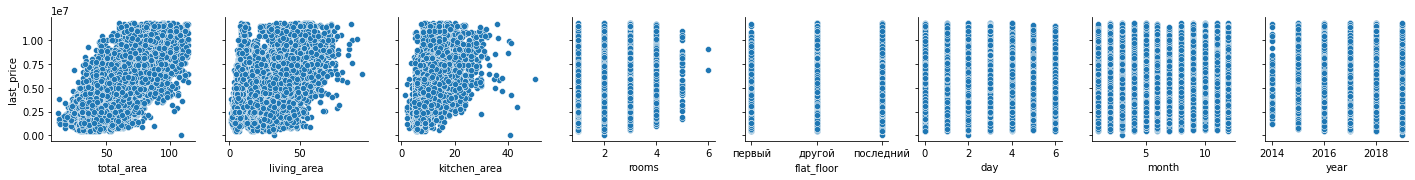

In [55]:
#рассчитаем зависимость цены от параметров (общей площади; жилой площади; площади кухни;
#количество комнат; типа этажа, на котором расположена квартира; - даты размещения (день недели, месяц, год);

sns.pairplot(good_data, x_vars=['total_area','living_area','kitchen_area','rooms','flat_floor','day','month','year']\
             , y_vars='last_price', diag_kind="hist");

***На цену квартиры сильнее всего влияет общая площадь (чем выше площадь, тем выше цена - прямая зависимость) и количество комнат. Сильное предпочтение заметно в двухкомнатных квартирах. Жилая площадь и площадь кухник не влияют на стоимость. Этаж и день подачи объявления также не влияет на цену.***

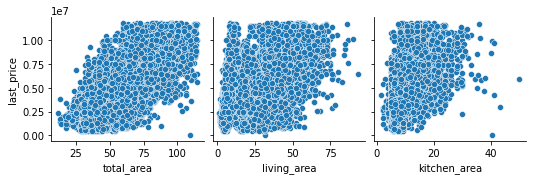

In [56]:
import seaborn as sns
sns.pairplot(good_data, x_vars=['total_area','living_area', 'kitchen_area'], y_vars='last_price', diag_kind="hist")

**Посчитаем среднюю цену 1 кв.м. в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

In [57]:
median_price_meter = good_data.pivot_table(index='locality_name', values='price_meter', aggfunc=['count', 'median', 'mean'])
median_price_meter.columns = ['count', 'median', 'mean']
median_price_meter.sort_values('count', ascending=False).head(10)

,count,median,mean
locality_name,,,
санкт-петербург,11914,101417.770,104544.684853
поселок мурино,521,84285.710,85035.348330
поселок шушары,429,76584.510,78271.164662
всеволожск,375,65789.470,67032.108747
поселок парголово,322,91984.435,90448.423416
колпино,315,74733.100,75407.591206
пушкин,299,98039.220,99659.197826
гатчина,284,67417.280,68329.851303
поселок кудрово,280,91666.670,92311.922964


## Вывод:

**В Санкт-Петербурге больше всего предложений и средняя цена метра значительно выше всех остальных населенных пунктов. Ну а дешевые квадратные метры стоит искать в Выборге.**

Выделим квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислим среднюю цену каждого километра. Также опишем, как стоимость объектов зависит от расстояния до центра города.

In [58]:
#выделим центр города
data['citycenter_km'] = data['citycenter_m'] / 1000
data['citycenter_km'] = data['citycenter_km'].astype('int', errors='ignore')
#обновляем чистые данные столбцом с километрами до центра
good_data = data[(data['too_large_area'] == False) & 
     (data['too_expensive'] == False) &
     #(data['too_many_rooms'] == False) &
     #(data['unusual_ceiling'] == False) &
     #(data['too_slow'] == False) &
     #(data['too_fast'] == False)].reset_index(drop=True)
    (data['unusual_ceiling'] == False)].reset_index(drop=True)
good_data.loc[(good_data['locality_name'] == 'санкт-петербург') & (good_data['citycenter_km'].notna()), 'citycenter_km'].apply(round)
spb = good_data.query('locality_name == "санкт-петербург"')
spb_center = spb.pivot_table(index='citycenter_km', values=['price_meter', 'last_price'], aggfunc='median')
spb_center.head()

,last_price,price_meter
citycenter_km,,
0.000,6900000,108163.270
0.001,7970000,110315.190
0.002,7865000,113153.845
0.003,6750000,106911.450
0.004,6875000,113439.560


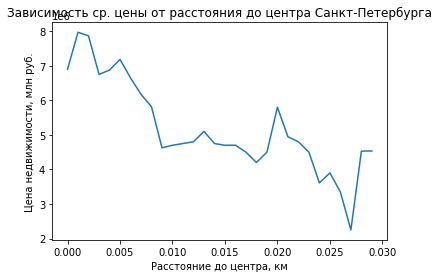

In [59]:
#построим график зависимости цены от расстояние до центра
sns.lineplot(x=spb_center.index, y='last_price', data=spb_center)
plt.title('Зависимость ср. цены от расстояния до центра Санкт-Петербурга')
plt.ylabel('Цена недвижимости, млн руб.')
plt.xlabel('Расстояние до центра, км')
plt.show()

На графике видно, что цена резко меняется начиная с 8 километра, область с таким радиусом и возьмем за центр города.

In [60]:
spb_center = good_data[(good_data['citycenter_km'] <= 8) & (good_data['locality_name'] == 'санкт-петербург')]

Проанализируем центральную территорию и изучим параметры: площадь, цена, число комнат и высота потолков.

In [61]:
spb_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,11883.000000,1.188300e+04,11883.000000,11883.000000
mean,52.573775,5.416613e+06,1.918455,2.630351
std,17.277582,1.937308e+06,0.870508,0.083546
min,12.000000,1.219000e+04,1.000000,2.450000
25%,39.400000,3.990000e+06,1.000000,2.560000
50%,48.700000,4.950000e+06,2.000000,2.650000
75%,62.900000,6.450000e+06,3.000000,2.650000
max,114.300000,1.180967e+07,6.000000,2.850000


На диагрммах размаха рассмотрим каждый показатель:

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


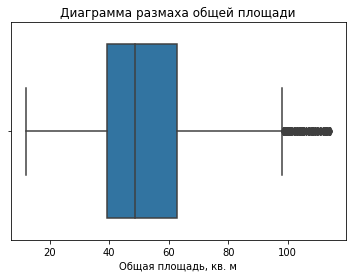

In [62]:
sns.boxplot(spb_center['total_area']) #построим диаграмму размаха для площади
plt.title('Диаграмма размаха общей площади')
plt.xlabel('Общая площадь, кв. м')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


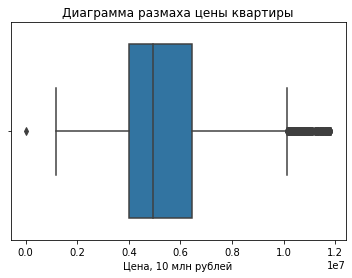

In [63]:
sns.boxplot(spb_center['last_price']) #построим диаграмму размаха для цены
plt.title('Диаграмма размаха цены квартиры')
plt.xlabel('Цена, 10 млн рублей')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


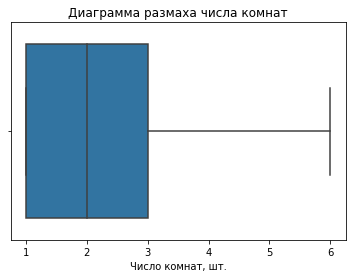

In [64]:
sns.boxplot(spb_center['rooms']) #построим диаграмму размаха для числа комнат
plt.title('Диаграмма размаха числа комнат')
plt.xlabel('Число комнат, шт.')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


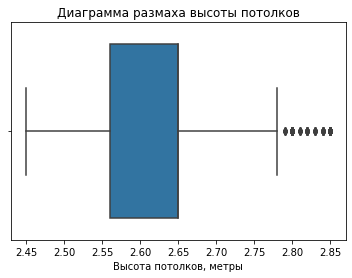

In [65]:
sns.boxplot(spb_center['ceiling_height']) #построим диаграмму размаха для высоты потолков
plt.title('Диаграмма размаха высоты потолков')
plt.xlabel('Высота потолков, метры')
plt.show()

In [66]:
#выделим факторы, которые влияют на стоимость квартиры в центре "Санкт-Петербурга"
corr = spb_center[['last_price',\
           'rooms',\
           'floor',\
           'citycenter_m',\
           'day',\
           'month',\
            'year'    
               ]].corr()
corr.style.background_gradient(cmap='coolwarm')

,last_price,rooms,floor,citycenter_m,day,month,year
last_price,1.000000,0.480176,0.127496,-0.277144,-0.002830,-0.001769,0.032612
rooms,0.480176,1.000000,-0.163951,-0.068485,-0.003298,0.001820,-0.028654
floor,0.127496,-0.163951,1.000000,0.161466,0.015015,0.007470,0.009953
citycenter_m,-0.277144,-0.068485,0.161466,1.000000,-0.017042,0.000509,0.068036
day,-0.002830,-0.003298,0.015015,-0.017042,1.000000,-0.002723,0.005953
month,-0.001769,0.001820,0.007470,0.000509,-0.002723,1.000000,-0.275126
year,0.032612,-0.028654,0.009953,0.068036,0.005953,-0.275126,1.000000


**Вывод:** В ходе исследовательской работы была определена средняя квартира, выставленная на продажу в центре Санкт-Петербурге. Рассмотрев полученные характеристики, можно сделать вывод, что в центре немного больше размеры квартир и цена превышает среднюю по общим данным.\
\
Можно отметить довольно сильную зависимость стоимости квартир от количества комнат и этажа. Также можно проследить зависимость от расстояния до центра, с удалением соответственно будет падать и цена.

# Общий вывод

Был проведен ряд исследований, и можно сказать какие параметры влияют на определение рыночной стоимости квартиры.

* общая площадь (50-60 кв.м. - золотая середина для квартир)
* число комнат (2-комнатные квартиры самые популярные)
* этаж квартиры (людям все также не нравятся первый и последний этажи)
* расстояние от центра города (повышенный спрос на квартиры ближе к центру)\
\
Выявленные аномалии:
1) необходимо выработать алгоритм, который не позволит вводить завышенные или заниженные значения для пользователя сайта. Это особенно касается высоты потолков и количества комнат в квартире.
2) Также необходимо отдельно проанализировать, что приводит к задержки на годы продажи части квартир, возможно разработать какие-то подсказки при заполнении, что поможет продавцу качественне заполнить данные и указать цену более реальную на сегодняшний день.
3) Квартиры, которые продавались за пару дней, стоит проверить, возможно это мошеннические действия, либо продавцы передумали продавать их, тогда узнать по какой причине.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод